This notebook explores the nodule dataframe created by the script `preprocessing/create_nodule_df.py`

In [4]:
from utils.common_imports import *
from project_config import env_config
import matplotlib.pyplot as plt

df = pd.read_csv(f"{env_config.nodule_df_file}")
df_hold_out_set = pd.read_csv(f"{env_config.hold_out_nodule_df_file}")
display(df.shape)
df.head(3)

(2625, 52)

,nodule_id,scan_id,nodule_idx,scan_slice_thickness,scan_slice_spacing,scan_pixel_spacing,scan_contrast_used,malignancy_scores,subtlety_scores,ann_internalStructure_scores,...,bbox_10_standardised,bbox_20_standardised,bbox_30_standardised,bbox_40_standardised,bbox_50_standardised,bbox_60_standardised,bbox_70_standardised,bbox_80_standardised,bbox_90_standardised,bbox_100_standardised
0,LIDC-IDRI-0001_0,LIDC-IDRI-0001,0,2.50,2.50,0.703125,True,"(5, 5, 5, 4)","(5, 5, 5, 5)","(1, 1, 1, 1)",...,True,True,True,True,True,True,True,True,True,True
1,LIDC-IDRI-0002_0,LIDC-IDRI-0002,0,1.25,1.25,0.681641,False,"(5, 4)","(2, 1)","(1, 1)",...,True,True,True,True,True,True,True,True,True,True
2,LIDC-IDRI-0003_0,LIDC-IDRI-0003,0,2.50,2.50,0.820312,True,"(2,)","(1,)","(1,)",...,True,True,True,True,True,True,True,True,True,True


In [3]:
# verify that no pids in the holdout set are in the processed nodule df
hold_out_pids = set(df_hold_out_set["pid"])
for p in set(df["pid"]):
    if p in hold_out_pids:
        print(f"{p} is in the hold out set")

KeyError: 'pid'

# EDA on Raw Attributes

## Malignancy distribution

In [ ]:
print("Consensus cancer rate in nodules:")
df["cancer_label"].value_counts()

Consensus cancer rate in nodules:


cancer_label
Ambiguous    1020
Benign        733
Malignant     388
Name: count, dtype: int64

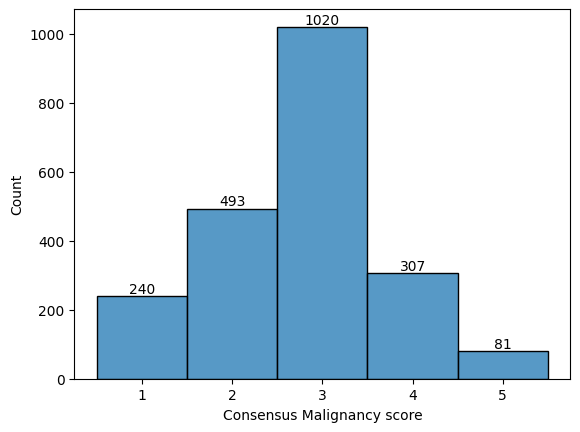

In [ ]:
sns.histplot(data=df, x="malignancy_consensus", discrete=True)
vals = df["malignancy_consensus"].value_counts().sort_index().values
for i in range(0, 5):
    plt.text(i+1, vals[i], vals[i], ha="center", va="bottom")
plt.xlabel("Consensus Malignancy score")
plt.show()

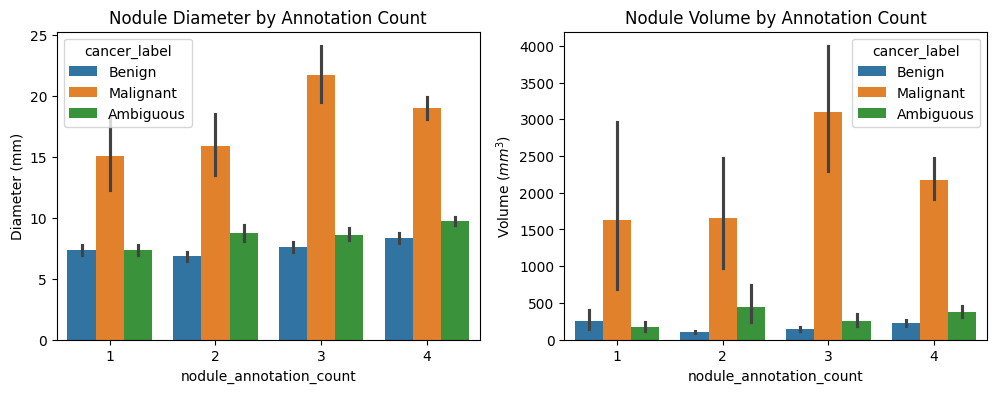

In [ ]:
# stratify on nodule annotation count, and plot diameter
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=df.query("nodule_annotation_count <= 4"), x="nodule_annotation_count", y="ann_mean_diameter", hue="cancer_label", ax=axs[0])
axs[0].set_title("Nodule Diameter by Annotation Count")
axs[0].set_ylabel("Diameter (mm)")
sns.barplot(data=df.query("nodule_annotation_count <= 4"), x="nodule_annotation_count", y="ann_mean_volume", hue="cancer_label", ax=axs[1])
axs[1].set_title("Nodule Volume by Annotation Count")
axs[1].set_ylabel("Volume $(mm^3)$")
plt.show()

In [ ]:
# check if the nodules with multiple annotations belongs to the patient with mutliple scans:
pids = df.query("nodule_annotation_count > 4")["pid"].tolist()

for p in pids:
    print(len(pl.query(pl.Scan).filter(pl.Scan.patient_id == p).all()))

1
1
1
1
1
1
1
1
1
1
1


# Nodule per patient

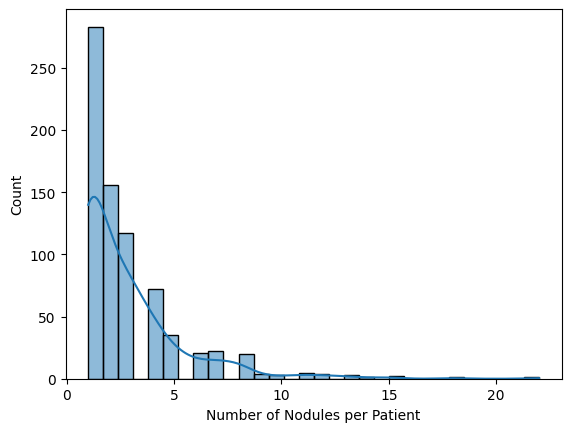

In [ ]:
# This is useful for when we need to make the datasplits and for cross validation
sns.histplot(df.groupby("pid").size(), bins=30, kde=True)
plt.xlabel("Number of Nodules per Patient")
plt.show()

# Nodules with 1 annotation

In [ ]:
one_ann_nod_df = df.query("nodule_annotation_count == 1")
one_ann_nod_df.head()

,index,pid,nodule_idx,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,subtlety_scores,margin_scores,...,bbox_within_scan_100,malignancy_consensus,subtlety_consensus,margin_consensus,cancer_label,fold_1,fold_2,fold_3,fold_4,fold_5
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,31.664468,4731.410934,"(102,)",1,"(2,)","(1,)","(2,)",...,True,2,1,2,Benign,test,train,train,train,train
9,2_LIDC-IDRI-0005,LIDC-IDRI-0005,2,6.264748,90.951783,"(109,)",1,"(2,)","(3,)","(5,)",...,False,2,3,5,Benign,train,train,train,test,train
10,0_LIDC-IDRI-0006,LIDC-IDRI-0006,0,6.987712,115.722656,"(116,)",1,"(2,)","(3,)","(5,)",...,True,2,3,5,Benign,train,train,train,test,train
12,2_LIDC-IDRI-0006,LIDC-IDRI-0006,2,15.051993,465.820312,"(123,)",1,"(2,)","(1,)","(2,)",...,True,2,1,2,Benign,train,train,train,test,train
15,0_LIDC-IDRI-0009,LIDC-IDRI-0009,0,7.370298,78.201294,"(136,)",1,"(2,)","(3,)","(5,)",...,True,2,3,5,Benign,train,train,test,train,train


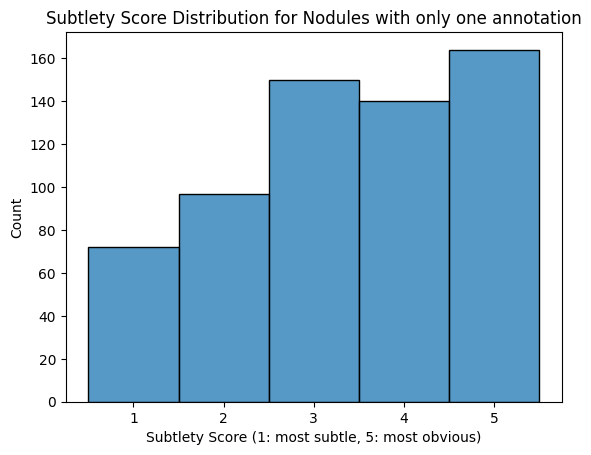

In [ ]:
# get subtlety score for nodules with only one annotation
# Intuitively, for the nodules with only one annotation, the subtlety distribution should be skewed towards 1 (most of the nodules should be subtle)
# however, this is not the case as we see below....
sns.histplot(data=one_ann_nod_df, x="subtlety_consensus", discrete=True)
plt.xlabel("Subtlety Score (1: most subtle, 5: most obvious)")
plt.title("Subtlety Score Distribution for Nodules with only one annotation")
plt.show()

# How many nodule consensus bbox's is within borders of scan?

In [ ]:
from utils.common_imports import *
nodule_df = pd.read_csv("out/nodule_df.csv")
nodule_df.columns

Index(['index', 'pid', 'nodule_idx', 'ann_mean_diameter', 'ann_mean_volume',
       'nodule_annotation_ids', 'nodule_annotation_count', 'malignancy_scores',
       'subtlety_scores', 'margin_scores', 'consensus_centroid',
       'consensus_bbox_10', 'consensus_bbox_20', 'consensus_bbox_30',
       'consensus_bbox_40', 'consensus_bbox_50', 'consensus_bbox_60',
       'consensus_bbox_70', 'consensus_bbox_80', 'consensus_bbox_90',
       'consensus_bbox_100', 'malignancy_consensus', 'subtlety_consensus',
       'cancer_label', 'bbox_10_standardised', 'bbox_20_standardised',
       'bbox_30_standardised', 'bbox_40_standardised', 'bbox_50_standardised',
       'bbox_60_standardised', 'bbox_70_standardised', 'bbox_80_standardised',
       'bbox_90_standardised', 'bbox_100_standardised'],
      dtype='object')

In [ ]:
cols = [c for c in nodule_df.columns if c.startswith("bbox_within_scan")]
plot_df = nodule_df[cols]
counts = plot_df.apply(lambda x: x.value_counts())
display(counts)
counts.T.plot(kind="bar", stacked=True, color=["red", "green"], figsize=(6, 4))
plt.title("Distribution of Nodules consensus bbox within scan\n for different bounding box sizes")
plt.ylabel("Count")
plt.xticks(ticks=range(len(cols)), labels=[int(x.split("_")[-1]) for x in cols])
plt.xlabel("Bounding Box Size")
plt.legend(["False", "True"], title="Values")
plt.show()

NameError: name 'nodule_df' is not defined

In [ ]:
nodule_df["bbox_within_scan_70"].value_counts()

bbox_within_scan_70
True     2141
False     237
Name: count, dtype: int64

## Inspect Nodule BBoxes that are not standardised

In [ ]:
from data.dataset import Nodule
import ast
from project_config import env_config
import pandas as pd
IMAGE_DIM = 70

nodule_df = pd.read_csv(
    f"{env_config.PROJECT_DIR}/preprocessing/processed_nodule_df.csv"
)
nodule_df[f"consensus_bbox_{IMAGE_DIM}"] = nodule_df[
    f"consensus_bbox_{IMAGE_DIM}"
].apply(ast.literal_eval)
nodule_df["nodule_annotation_ids"] = nodule_df[
    "nodule_annotation_ids"
].apply(ast.literal_eval)
nodule_df.columns

Index(['nodule_id', 'scan_id', 'nodule_idx', 'scan_slice_thickness',
       'scan_slice_spacing', 'scan_pixel_spacing', 'scan_contrast_used',
       'malignancy_scores', 'subtlety_scores', 'ann_internalStructure_scores',
       'ann_calcification_scores', 'ann_sphericity_scores',
       'ann_margin_scores', 'ann_lobulation_scores', 'ann_spiculation_scores',
       'ann_texture_scores', 'nodule_annotation_ids',
       'nodule_annotation_count', 'ann_mean_diameter', 'ann_mean_volume',
       'consensus_centroid', 'consensus_bbox_10', 'consensus_bbox_20',
       'consensus_bbox_30', 'consensus_bbox_40', 'consensus_bbox_50',
       'consensus_bbox_60', 'consensus_bbox_70', 'consensus_bbox_80',
       'consensus_bbox_90', 'consensus_bbox_100', 'malignancy_consensus',
       'cancer_label', 'subtlety_consensus', 'internalStructure_consensus',
       'calcification_consensus', 'sphericity_consensus', 'margin_consensus',
       'lobulation_consensus', 'spiculation_consensus', 'texture_consensu

0it [00:00, ?it/s]


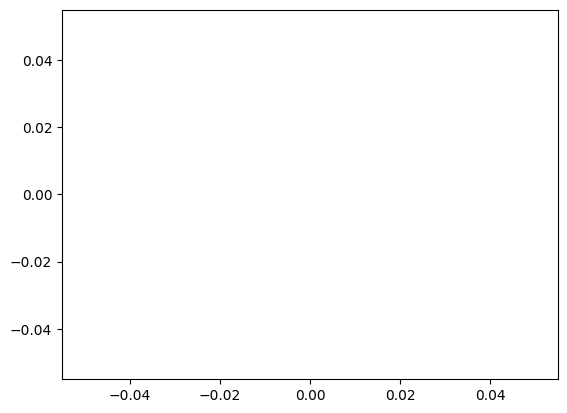

In [ ]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

non_standardised = nodule_df.query(f"bbox_{IMAGE_DIM}_standardised == False")

"""NOTE: it is very often the z-dimension that lacks exceeds the border of the scan at max img dim.
Maybe we could use a lower dim on the z-dimension to not exclude images."""
z_shapes = []
for i in tqdm(range(len(non_standardised))):
    n = Nodule(nodule_record=non_standardised.iloc[i], nodule_context_size=IMAGE_DIM)
    z_shapes.append(n.nodule_roi.shape[-1])

sns.histplot(z_shapes)
plt.show()

# %matplotlib widget
# n.visualise_nodule_bbox()

In [ ]:
np.histogram(np.array(z_shapes), bins=[30, 40, 50, 60, 70, 70])

(array([  0,  12, 101, 159,   6]), array([30, 40, 50, 60, 70, 70]))

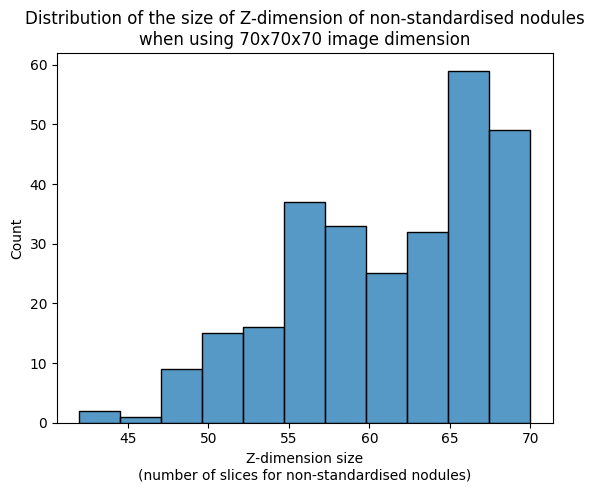

In [ ]:
sns.histplot(z_shapes)
plt.title("Distribution of the size of Z-dimension of non-standardised nodules\nwhen using 70x70x70 image dimension")
plt.xlabel("Z-dimension size\n(number of slices for non-standardised nodules)")
plt.show()

# Filtering

In [ ]:
fil_df = df.query("cancer_label != 'Ambiguous'")
fil_df["cancer_label"] = fil_df["cancer_label"].map({"Benign": 0, "Malignant": 1})
fil_df

# display(fil_df["cancer_label"].value_counts(normalize=True))

/var/folders/_c/vr22_fg12d7flyy_ll_m264w0000gp/T/ipykernel_56993/165000911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fil_df["cancer_label"] = fil_df["cancer_label"].map({"Benign": 0, "Malignant": 1})


,index,pid,nodule_idx,ann_mean_diameter,ann_mean_volume,nodule_annotation_ids,nodule_annotation_count,malignancy_scores,subtlety_scores,margin_scores,...,bbox_within_scan_128,malignancy_consensus,subtlety_consensus,margin_consensus,cancer_label,fold_1,fold_2,fold_3,fold_4,fold_5
0,0_LIDC-IDRI-0001,LIDC-IDRI-0001,0,32.755812,6989.673615,"(84, 85, 86, 87)",4,"(5, 5, 5, 4)","(5, 5, 5, 5)","(3, 4, 2, 4)",...,False,5,5,3,1,test,train,train,train,train
1,0_LIDC-IDRI-0002,LIDC-IDRI-0002,0,30.781671,7244.667508,"(88, 89)",2,"(5, 4)","(2, 1)","(1, 2)",...,True,5,2,2,1,train,train,test,train,train
2,0_LIDC-IDRI-0003,LIDC-IDRI-0003,0,31.664468,4731.410934,"(102,)",1,"(2,)","(1,)","(2,)",...,True,2,1,2,0,train,test,train,train,train
3,1_LIDC-IDRI-0003,LIDC-IDRI-0003,1,31.001964,6519.463698,"(90, 93, 98, 99)",4,"(5, 5, 3, 4)","(5, 5, 5, 5)","(3, 3, 3, 4)",...,True,4,5,3,1,train,test,train,train,train
5,3_LIDC-IDRI-0003,LIDC-IDRI-0003,3,14.983128,1313.229390,"(92, 94, 96, 101)",4,"(4, 5, 3, 2)","(4, 5, 4, 3)","(5, 5, 5, 5)",...,False,4,4,5,1,train,test,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,0_LIDC-IDRI-1011,LIDC-IDRI-1011,0,28.675805,6039.291382,"(4484, 4486, 4489, 4492)",4,"(4, 3, 4, 3)","(5, 5, 5, 5)","(4, 3, 4, 5)",...,True,4,5,4,1,train,train,train,test,train
2621,1_LIDC-IDRI-1011,LIDC-IDRI-1011,1,32.859210,4170.822144,"(4483, 4487, 4490, 4493)",4,"(3, 5, 5, 5)","(5, 5, 5, 5)","(5, 2, 4, 4)",...,False,5,5,4,1,train,train,train,test,train
2622,2_LIDC-IDRI-1011,LIDC-IDRI-1011,2,22.721655,2185.342789,"(4482, 4485, 4488, 4494)",4,"(2, 5, 5, 5)","(3, 5, 5, 5)","(3, 2, 3, 4)",...,False,4,5,3,1,train,train,train,test,train
2623,3_LIDC-IDRI-1011,LIDC-IDRI-1011,3,6.544805,92.315674,"(4491,)",1,"(2,)","(1,)","(2,)",...,False,2,1,2,0,train,train,train,test,train
